# Urban Air Pollution Prediction

## 1. Packages

In [1]:
# Dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Maths
from statistics import mean

# extra
import os


## 2. Import Data into Dataframe

In [2]:
# load files into a pandas DataFrame
train = pd.read_csv("Train.csv")
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
# Let's observe the shape of our datasets.
print('Train datashape: ', train.shape)
print('Test Data Shape: ', test.shape)

Train datashape:  (30557, 82)
Test Data Shape:  (16136, 77)


The above output shows number of rows and columns for train and test dataset.
In train dataset we have 82 variables, 77 independent variables and 5 dependent variables.

In Test dataset we have 77 independent variables.

We can observe the first five rows from our data set by using the head() method from the pandas library

In [4]:
def wrangle(filepath):
    print("==== WRANGLE WRANGLING ====")
    try:
        df = pd.read_csv(filepath)
    except:
        print("Error importing file")
        
    else:
        filename = os.path.basename(filepath)
        print("Dealing with file: ", filename)
        
        # Drop columns that are more than half NaN values
        print('Before drop NaN:', df.shape)
        df = df.dropna(thresh=len(df.index)/2, axis=1)
        print('After dropping NaN:', df.shape)
        
        # drop unique id columns
        # df = df.drop(columns=["Place_ID X Date"])

        # Convert date column to timestamps
        df['Date'] = pd.to_datetime(df['Date'])
        df['Date'] = df['Date'].astype('int64') # 10**9

        # one-hot encoding 
        # place_id_dummies = pd.get_dummies(df['Place_ID'], prefix='Place_ID')
        # df = pd.concat([df, place_id_dummies], axis=1)
        # df.drop('Place_ID', axis=1, inplace=True)

        # drop rows with missing values
        # df.dropna(inplace=True)
        
        if (filepath == 'Train.csv'):
            try:
                # Remove outliers with readings above 500
                df = df[df["target"] < 500]
                
                # Drop leaky columns
                df.drop(columns=['target_min', 'target_max', 'target_variance', 'target_count'], inplace=True)
                print("Dropped Leaky columns", df.shape)
            finally:
                print("Done removing outliers and leaky columns")
        print("==== WRANGLE WRANGLED ====\n")
    return df

In [5]:
train = wrangle('Train.csv')
test = wrangle('Test.csv')

==== WRANGLE WRANGLING ====
Dealing with file:  Train.csv
Before drop NaN: (30557, 82)
After dropping NaN: (30557, 75)
Dropped Leaky columns (30552, 71)
Done removing outliers and leaky columns
==== WRANGLE WRANGLED ====

==== WRANGLE WRANGLING ====
Dealing with file:  Test.csv
Before drop NaN: (16136, 77)
After dropping NaN: (16136, 70)
==== WRANGLE WRANGLED ====



In [6]:
test.shape

(16136, 70)

## 3. Explore

In [7]:
# Calculate unique values for each non-numeric feature in dataset
train.select_dtypes(include=['object']).nunique()
train.shape

(30552, 71)

In [8]:
cardinality = train.select_dtypes(include=['object']).nunique()
cardinality

Place_ID X Date    30552
Place_ID             340
dtype: int64

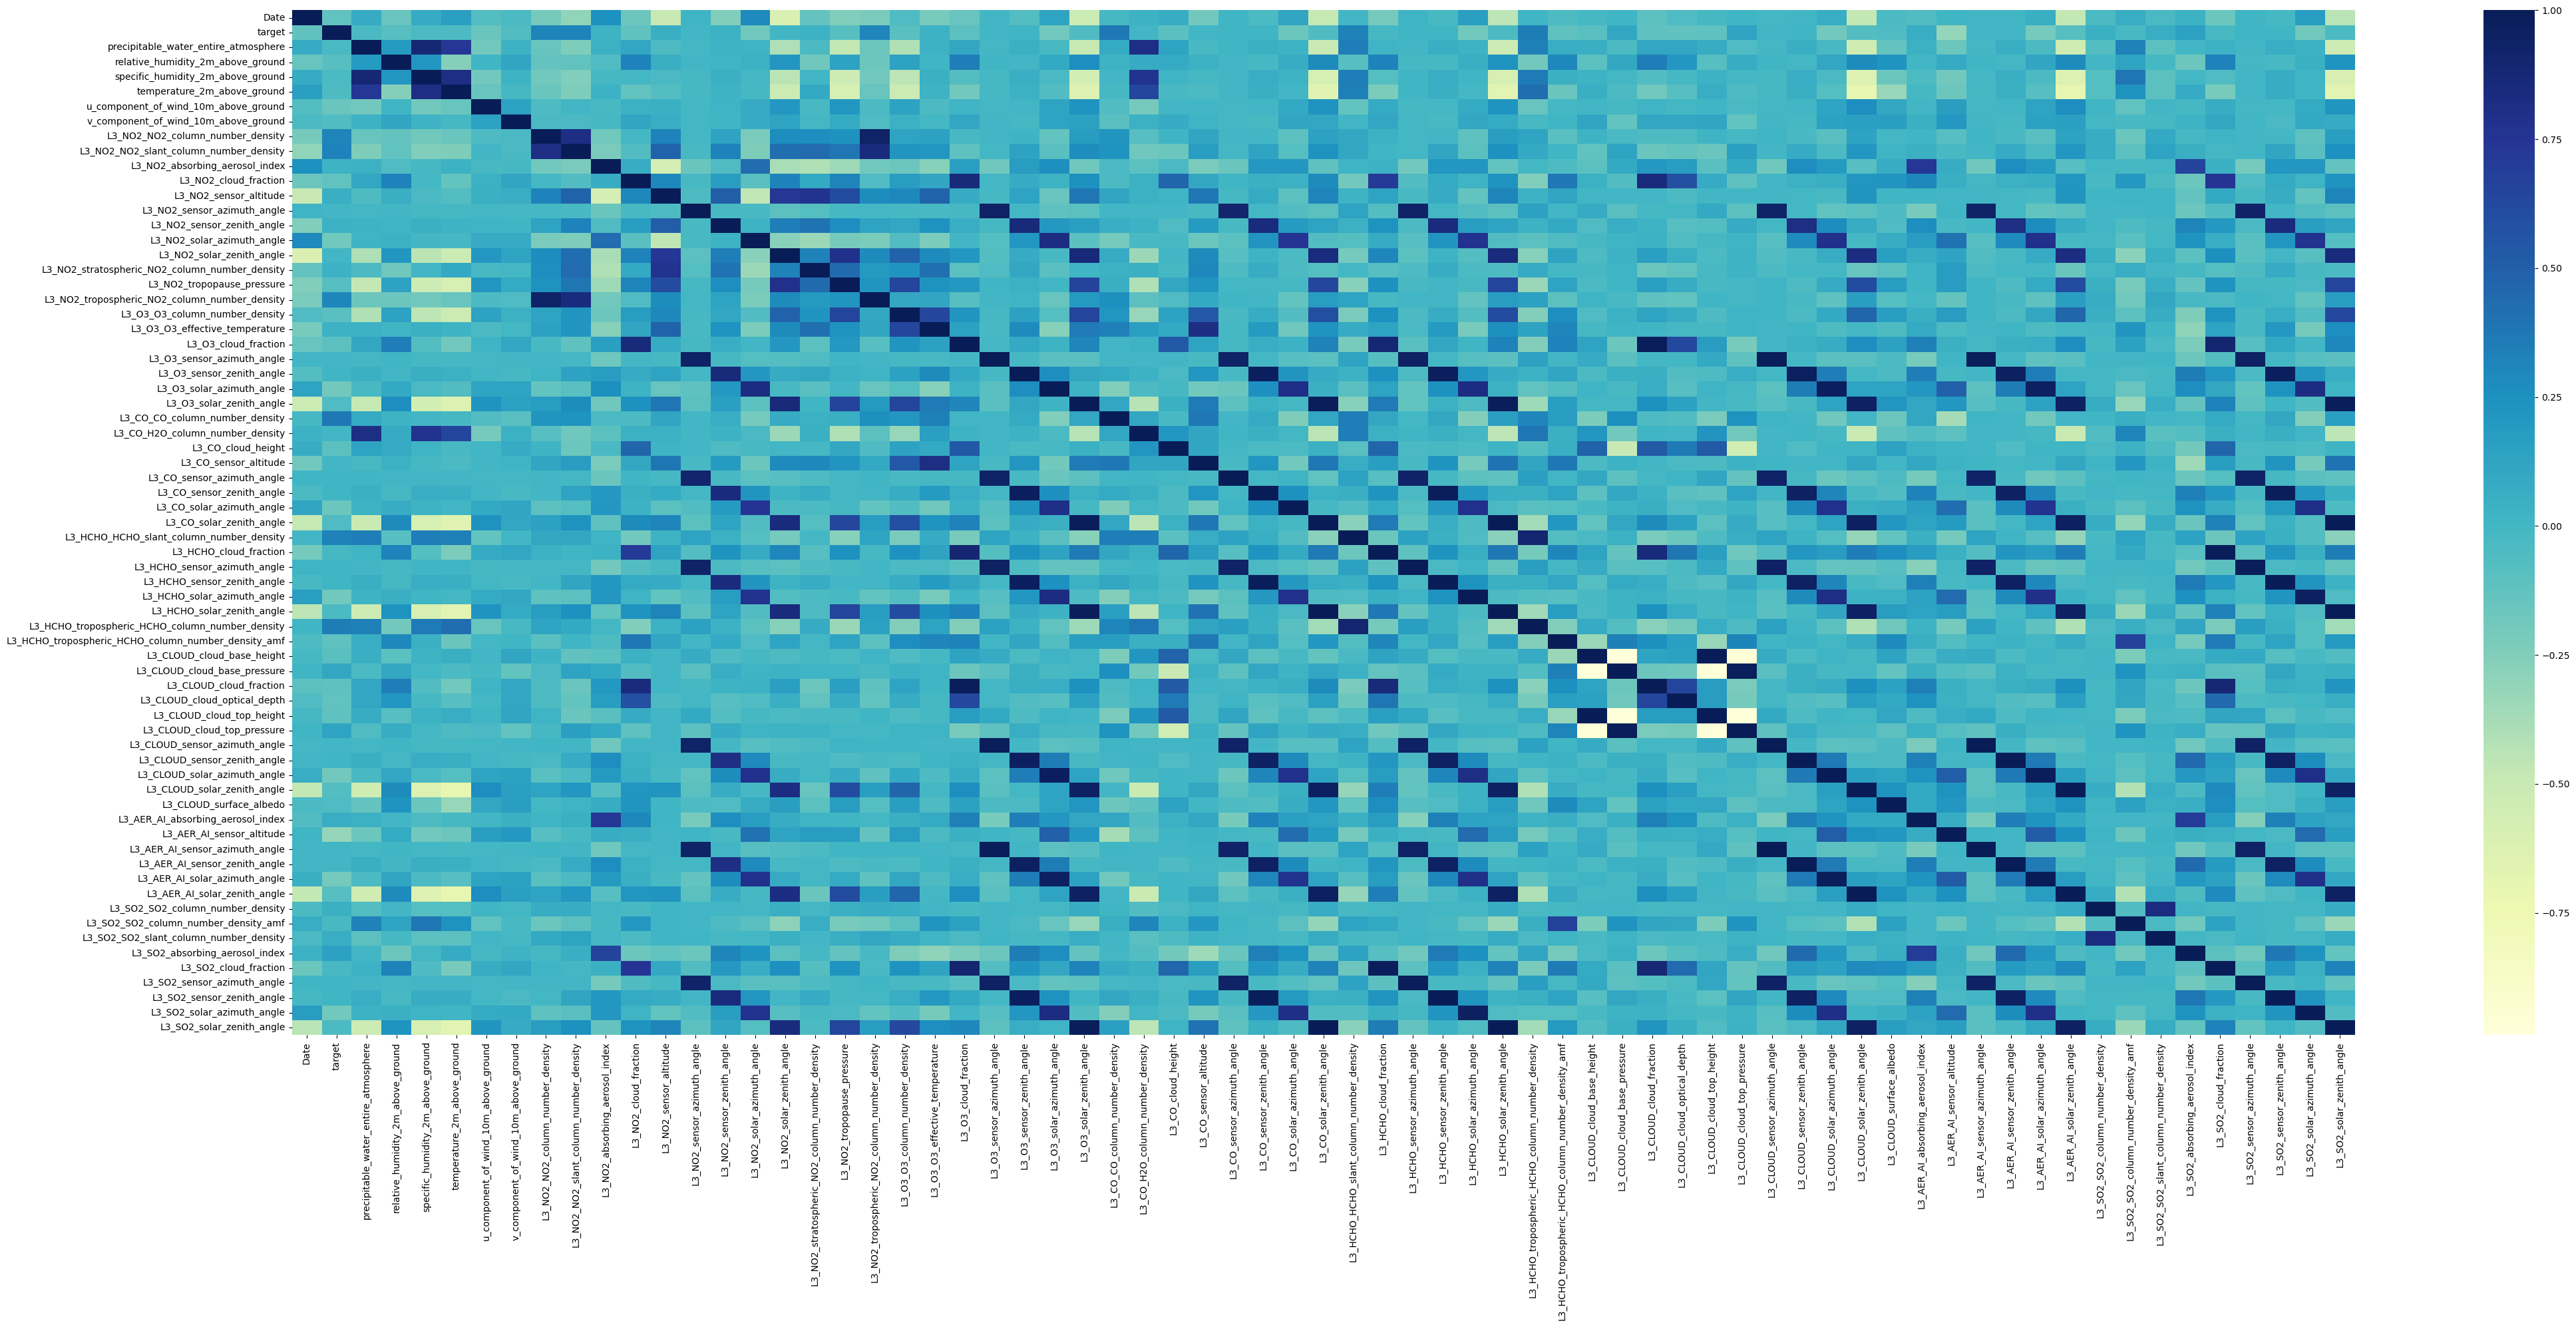

In [9]:
# For interpretability correlation should be applied but interest in performance metric is not a big deal
corr = train.select_dtypes("number").corr()


# Set the figure size
plt.figure(figsize=(50, 20))

# Create the heatmap
sns.heatmap(corr, cmap="YlGnBu")

plt.show()

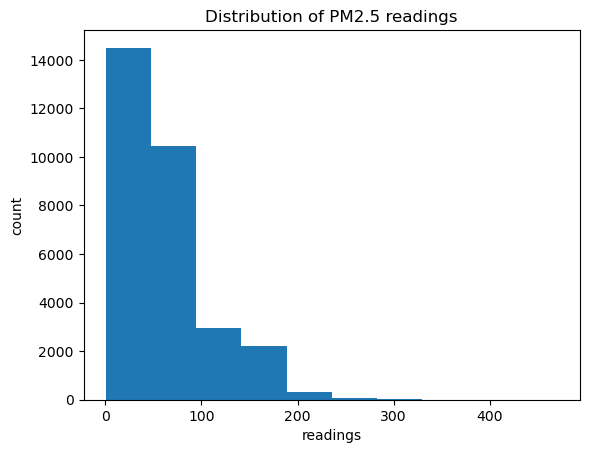

In [10]:
# Build histogram for distribution of target
plt.hist(train["target"])

# Label axes
plt.xlabel("readings")
plt.ylabel("count")

# Add title
plt.title("Distribution of PM2.5 readings");

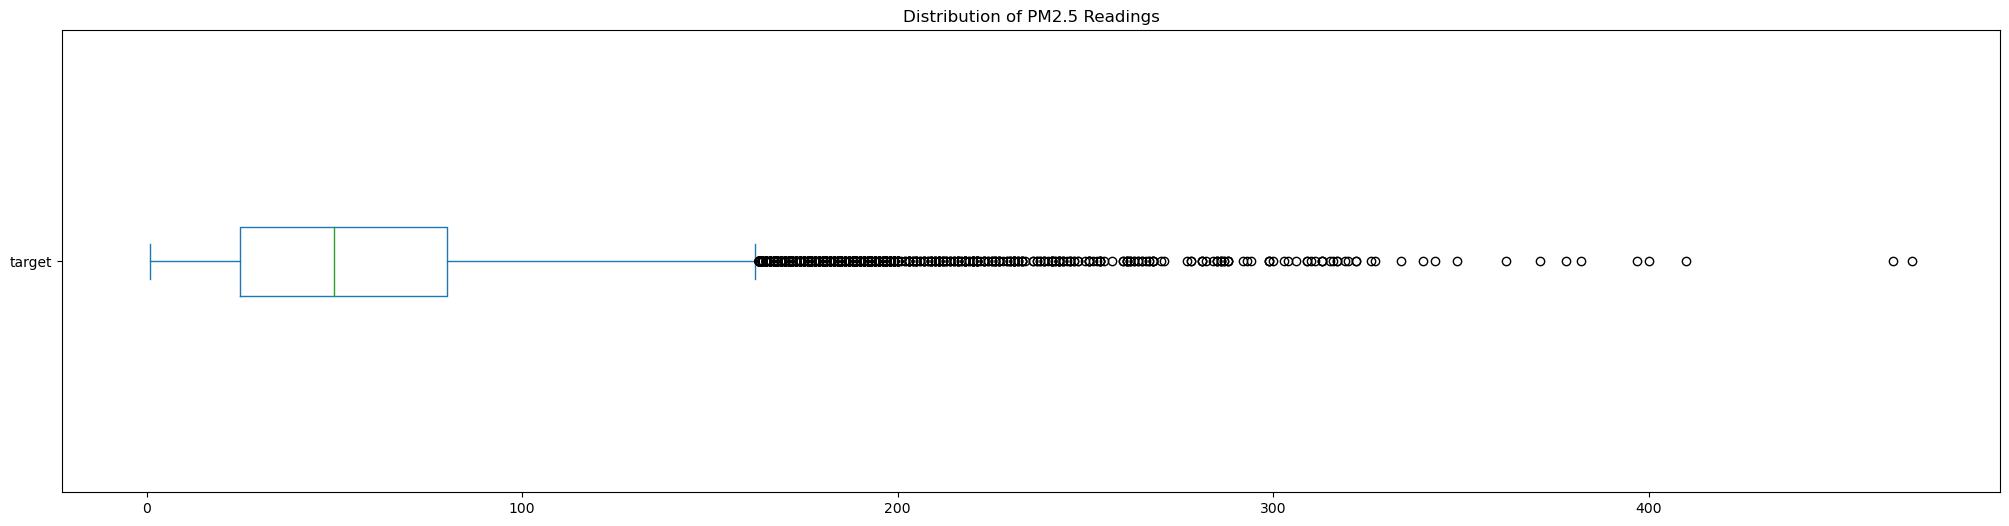

In [11]:
# Check for outliers
fig, ax = plt.subplots(figsize=(25, 6))
train["target"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);

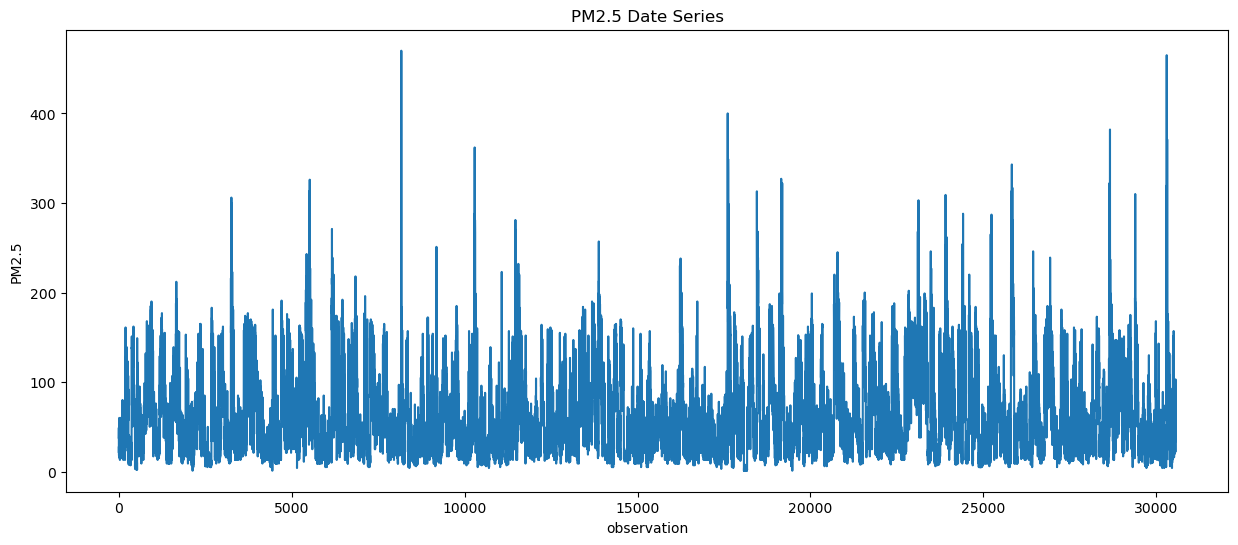

In [12]:
# Create a time series plot for "target" in the train dataset
fig, ax = plt.subplots(figsize=(15, 6))

train["target"].plot(xlabel="observation", ylabel="PM2.5", title="PM2.5 Date Series", ax=ax);

# There is no any missing data from the target column

## 4. Split

In [13]:
target = "target"
y_train = train[target]
processed_train = train.drop(columns=[target, 'Place_ID X Date', 'Date', 'Place_ID'])

### 4.2 Split train data

Only 10% of the train dataset will be used for evaluating the models. The parameter stratify = y_train will ensure an equal balance of values from both classes for both train and validation set.

In [14]:
# Split train_data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(processed_train, y_train, test_size = 0.1, random_state=42)

### 4.3 Impute missing Values

## 5. Build Model

### 5.1 Baseline

In [15]:
y_mean = mean(y_train)

y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 6))
print("Baseline MAE:", round(mae_baseline, 6))

Mean P2 Reading: 61.195767
Baseline MAE: 34.856543


In [17]:
from sklearn.impute import SimpleImputer

# create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# impute missing values in X
X_train = imputer.fit_transform(X_train)
X_val = imputer.fit_transform(X_val)
test = imputer.fit_transform(test.drop(columns=['Place_ID X Date', 'Date', 'Place_ID']))

### 5.2 Iterate

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 5.3 Evaluate Model

In [19]:
# y_pred_training = model.predict(X)
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_val, model.predict(X_val))
print("Training MAE:", round(training_mae, 6))
print("Test MAE:", round(test_mae, 6))

Training MAE: 26.704209
Test MAE: 25.934044


### 5.4 Making the first submission
Let’s now see how the model performs on the competition test data set provided and how we rank on the competition leaderboard.

First, we make predictions on the competition test data set.

In [20]:
# Get the predicted result for the test Data
test_predictions = model.predict(test)

In [ ]:
# Revert date to original format
test['Date'] = pd.to_datetime(test['Date'])

# revert the 'Date' column to a string
test['Date'] = test['Date'].dt.strftime('%Y-%m-%d')

In [22]:
submission = pd.DataFrame({
    "Place_ID X Date": ss["Place_ID X Date"],
    "target": test_predictions
})

In [23]:
submission.head()


,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,45.914932
1,0OS9LVX X 2020-01-03,20.158072
2,0OS9LVX X 2020-01-04,17.445400
3,0OS9LVX X 2020-01-05,14.861136
4,0OS9LVX X 2020-01-06,29.397791


In [24]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16136 entries, 0 to 16135
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Place_ID X Date  16136 non-null  object 
 1   target           16136 non-null  float64
dtypes: float64(1), object(1)
memory usage: 252.2+ KB


Creating CSV file to submit

In [25]:
# Create submission csv file csv file
submission.to_csv('trial3.csv', index = False)